In [1]:
import osmium as osm
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.image as mpimg
from sklearn.cluster import DBSCAN
import numpy as np
import os
from collections import Counter
from math import radians, cos, sin, asin, sqrt

# Setze den Pfad zum Dataset
dataset_path = os.path.join("Datasets", "ringheim.osm")
filename = os.path.basename(dataset_path)
title = filename.split('.')[0].capitalize()

### Datensatz um alle Daten auszulesen

In [2]:
class OSMHandler(osm.SimpleHandler):
    def __init__(self):
        osm.SimpleHandler.__init__(self)
        self.osm_data = []

    def tag_inventory(self, elem, elem_type, lon=None, lat=None, node_ids=None):
        if len(elem.tags) == 0:
            # Für Knoten ohne Tags
            self.osm_data.append([elem_type, 
                                  elem.id, 
                                  elem.visible, 
                                  0, 
                                  None, 
                                  None, 
                                  lon, 
                                  lat, 
                                  node_ids])
        else:
            for tag in elem.tags:
                self.osm_data.append([elem_type, 
                                      elem.id,
                                      elem.visible,
                                      len(elem.tags),
                                      tag.k, 
                                      tag.v, lon, lat, node_ids])

    def node(self, n):
        self.tag_inventory(n, "node", lon=n.location.lon, lat=n.location.lat)

    def way(self, w):
        node_ids = [n.ref for n in w.nodes]  
        self.tag_inventory(w, "way", node_ids=node_ids)

# Daten auslesen
osmhandler = OSMHandler()
osmhandler.apply_file(dataset_path)

# DataFrame erstellen
data_colnames = ['type', 'id', 'visible', 'ntags', 'tagkey', 'tagvalue', 'longitude', 'latitude', 'node_ids']
df_osm = pd.DataFrame(osmhandler.osm_data, columns=data_colnames)
df_osm

,type,id,visible,ntags,tagkey,tagvalue,longitude,latitude,node_ids
0,node,27345586,True,0,None,None,9.046306,49.936876,None
1,node,27345587,True,0,None,None,9.047442,49.935329,None
2,node,27345588,True,0,None,None,9.043650,49.933117,None
3,node,27345589,True,0,None,None,9.038758,49.939419,None
4,node,27345590,True,0,None,None,9.033599,49.938876,None
...,...,...,...,...,...,...,...,...,...
16968,way,1240964568,True,5,barrier,fence,NaN,NaN,"[11530301528, 11530301529, 11530301530, 115303..."
16969,way,1240964568,True,5,basin,infiltration,NaN,NaN,"[11530301528, 11530301529, 11530301530, 115303..."
16970,way,1240964568,True,5,intermittent,yes,NaN,NaN,"[11530301528, 11530301529, 11530301530, 115303..."
16971,way,1240964568,True,5,natural,water,NaN,NaN,"[11530301528, 11530301529, 11530301530, 115303..."


### Datensatz für Straßen

In [3]:
ways_filter = df_osm[(df_osm['type'] == 'way') & (df_osm['tagkey'] == 'highway')]
ways_filter

,type,id,visible,ntags,tagkey,tagvalue,longitude,latitude,node_ids
10170,way,23007687,True,2,highway,residential,NaN,NaN,"[248048834, 747099113, 8303726883]"
10172,way,23007688,True,11,highway,residential,NaN,NaN,"[248048848, 9139728662, 437320548, 571948467, ..."
10183,way,23007689,True,2,highway,residential,NaN,NaN,"[248048871, 248048886]"
10185,way,23008238,True,8,highway,residential,NaN,NaN,"[278284673, 3426708192, 570856940, 292552794, ..."
10193,way,23008345,True,3,highway,residential,NaN,NaN,"[248048876, 248048878, 248048879, 8252930929, ..."
...,...,...,...,...,...,...,...,...,...
16886,way,1096884087,True,2,highway,service,NaN,NaN,"[10044053994, 10044053995]"
16917,way,1154590283,True,11,highway,residential,NaN,NaN,"[9362709151, 9362709150]"
16928,way,1154590284,True,11,highway,residential,NaN,NaN,"[382205234, 570857299, 570857237, 570857287, 5..."
16944,way,1197048147,True,13,highway,residential,NaN,NaN,"[571948709, 3426707915]"


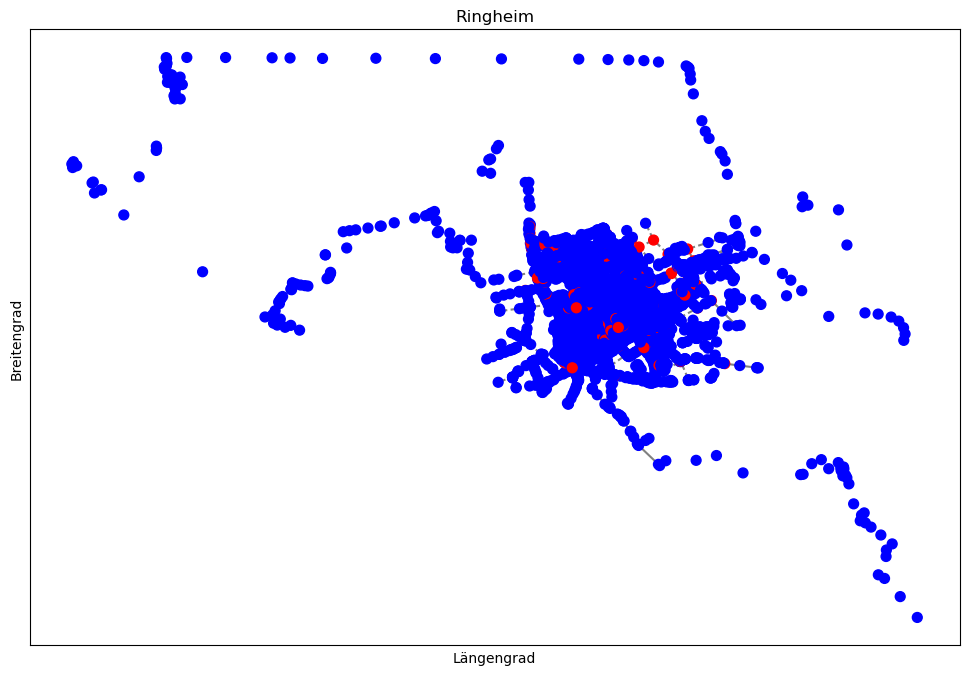

In [4]:
G = nx.Graph()

# Knoten zum Graphen hinzufügen
for index, row in df_osm.iterrows():  
    if pd.notnull(row['longitude']) and pd.notnull(row['latitude']):
        G.add_node(row['id'], pos=(row['longitude'], row['latitude']))

# Kanten zum Graphen hinzufügen
for index, way in ways_filter.iterrows():
    node_ids_list = way['node_ids']
    if node_ids_list is not None:
        filtered_node_ids_list = [node_id for node_id in node_ids_list if G.has_node(node_id)]
        if len(filtered_node_ids_list) > 1:
            for i in range(len(filtered_node_ids_list) - 1):
                is_dashed_highway = way['tagkey'] == 'highway' and way['tagvalue'] not in ['residential', 'unclassified', 'service', 'tertiary', 'secondary']
                G.add_edge(
                    filtered_node_ids_list[i], filtered_node_ids_list[i + 1],
                    street_name=way['tagvalue'],
                    is_dashed_highway=is_dashed_highway
                )

pos = nx.get_node_attributes(G, 'pos')

plt.figure(figsize=(12, 8))

# Normale Kanten zeichnen
edges_normal = [(u, v) for u, v, d in G.edges(data=True) if not d.get('is_dashed_highway')]
nx.draw_networkx_edges(G, pos, edgelist=edges_normal, edge_color='gray', width=1.5)

# Gestrichelte Kanten zeichnen
edges_dashed = [(u, v) for u, v, d in G.edges(data=True) if d.get('is_dashed_highway')]
nx.draw_networkx_edges(G, pos, edgelist=edges_dashed, edge_color='gray', width=1.5, style='--')

node_degrees = dict(G.degree())
node_color = ['red' if node_degrees[node] >= 3 else 'blue' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_color)

# Optional: Kantenbeschriftungen mit Straßennamen anzeigen
# edge_labels = nx.get_edge_attributes(G, 'street_name')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='red')

plt.title(title)
plt.xlabel("Längengrad")
plt.ylabel("Breitengrad")
plt.show()

### Haversine Formel für die Längenberechnung

In [5]:
def haversine(lon1, lat1, lon2, lat2):
    # Dezimalzahlen in Radianten umwandeln
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine Formel
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius der Erde in Kilometer
    return c * r * 1000

### Straßenlänge berechnen

In [6]:
def calculate_full_road_length(way_row, df_nodes):
    node_ids = way_row['node_ids']
    total_length = 0

    for i in range(len(node_ids) - 1):
        first_node = df_nodes[df_nodes['id'] == node_ids[i]]
        second_node = df_nodes[df_nodes['id'] == node_ids[i + 1]]

        # Überprüfung, ob beide Knoten existieren
        if first_node.empty or second_node.empty:
            return None

        total_length += haversine(
            first_node['longitude'].values[0], first_node['latitude'].values[0],
            second_node['longitude'].values[0], second_node['latitude'].values[0]
        )

    return total_length

road_lengths = []

for index, way_row in ways_filter.iterrows():
    length = calculate_full_road_length(way_row, df_osm)
    if length is not None:
        road_lengths.append({'way_id': way_row['id'], 'length': length})

df_road_length = pd.DataFrame(road_lengths)

df_road_length

,way_id,length
0,23007687,151.848568
1,23007688,392.044903
2,23007689,139.941911
3,23008238,241.943803
4,23008345,257.506382
...,...,...
300,1096884087,13.126712
301,1154590283,17.567383
302,1154590284,183.188391
303,1197048147,27.724026


### Datensatz auf nur Kreuzungspunkte reduzieren

In [7]:
all_node_ids = []
for node_ids_list in ways_filter['node_ids']:
    if node_ids_list is not None:
        all_node_ids.extend(node_ids_list)

node_reference_count = Counter(all_node_ids)

nodes_referenced_multiple = {node_id for node_id, count in node_reference_count.items() if count > 1}

df_nodes_filtered_multiple = df_osm[(df_osm['type'] == 'node') & (df_osm['id'].isin(nodes_referenced_multiple))]

filtered_data_multiple = pd.concat([ways_filter, df_nodes_filtered_multiple], ignore_index=True)

filtered_data_multiple

,type,id,visible,ntags,tagkey,tagvalue,longitude,latitude,node_ids
0,way,23007687,True,2,highway,residential,NaN,NaN,"[248048834, 747099113, 8303726883]"
1,way,23007688,True,11,highway,residential,NaN,NaN,"[248048848, 9139728662, 437320548, 571948467, ..."
2,way,23007689,True,2,highway,residential,NaN,NaN,"[248048871, 248048886]"
3,way,23008238,True,8,highway,residential,NaN,NaN,"[278284673, 3426708192, 570856940, 292552794, ..."
4,way,23008345,True,3,highway,residential,NaN,NaN,"[248048876, 248048878, 248048879, 8252930929, ..."
...,...,...,...,...,...,...,...,...,...
759,node,10031437751,True,0,None,None,9.031585,49.933697,None
760,node,10031443840,True,0,None,None,9.032312,49.933804,None
761,node,10031481446,True,0,None,None,9.031907,49.932299,None
762,node,10044053995,True,0,None,None,9.037636,49.930208,None


### Graph vor dem Entfernen der Grad-2-Knoten

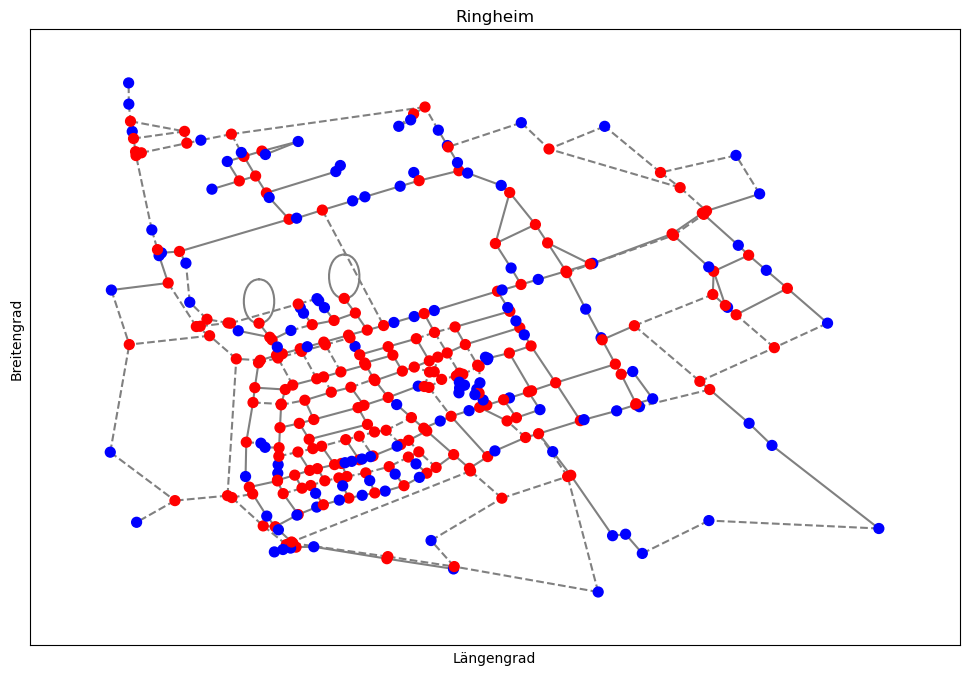

In [8]:
G = nx.Graph()

# Knoten zum Graphen hinzufügen
for index, row in filtered_data_multiple.iterrows():  
    if pd.notnull(row['longitude']) and pd.notnull(row['latitude']):
        G.add_node(row['id'], pos=(row['longitude'], row['latitude']))

# Kanten zum Graphen hinzufügen
for index, way in ways_filter.iterrows():
    node_ids_list = way['node_ids']
    if node_ids_list is not None:
        filtered_node_ids_list = [node_id for node_id in node_ids_list if G.has_node(node_id)]
        if len(filtered_node_ids_list) > 1:
            for i in range(len(filtered_node_ids_list) - 1):
                is_dashed_highway = way['tagkey'] == 'highway' and way['tagvalue'] not in ['residential', 'unclassified', 'service', 'tertiary', 'secondary']
                G.add_edge(
                    filtered_node_ids_list[i], filtered_node_ids_list[i + 1],
                    street_name=way['tagvalue'],
                    is_dashed_highway=is_dashed_highway
                )

pos = nx.get_node_attributes(G, 'pos')

plt.figure(figsize=(12, 8))

# Normale Kanten zeichnen
edges_normal = [(u, v) for u, v, d in G.edges(data=True) if not d.get('is_dashed_highway')]
nx.draw_networkx_edges(G, pos, edgelist=edges_normal, edge_color='gray', width=1.5)

# Gestrichelte Kanten zeichnen
edges_dashed = [(u, v) for u, v, d in G.edges(data=True) if d.get('is_dashed_highway')]
nx.draw_networkx_edges(G, pos, edgelist=edges_dashed, edge_color='gray', width=1.5, style='--')

node_degrees = dict(G.degree())
node_color = ['red' if node_degrees[node] >= 3 else 'blue' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_color)

# Optional: Kantenbeschriftungen mit Straßennamen anzeigen
# edge_labels = nx.get_edge_attributes(G, 'street_name')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='red')

plt.title(title)
plt.xlabel("Längengrad")
plt.ylabel("Breitengrad")
plt.show()

### Knoten vom Grad 2 entfernen

In [9]:
G = nx.Graph()

# Entfernen von Knoten mit Grad 2 aus den node-ids
def remove_degree_2_nodes(node_ids):
    if node_ids is not None:
        return [node_id for node_id in node_ids if node_id not in degree_2_node_ids]
    return node_ids

# 2 Grad-3+-Nachbarn finden
def find_neighbors_with_degree_3(node_id, visited=None, found_neighbors=None):
    if visited is None:
        visited = set()
    if found_neighbors is None:
        found_neighbors = []

    visited.add(node_id)
    neighbors = list(G.neighbors(node_id))

    for neighbor in neighbors:
        if neighbor not in visited:
            neighbor_degree = G.degree(neighbor)

            # Füge Nachbarn hinzu, wenn er Grad 3 oder höher hat
            if neighbor_degree >= 3:
                found_neighbors.append(neighbor)

                # Stoppe, wenn zwei passende Nachbarn gefunden wurden
                if len(found_neighbors) == 2:
                    return found_neighbors

            # Rekursive Suche fortsetzen, wenn der Nachbar Grad 2 hat
            elif neighbor_degree == 2:
                result = find_neighbors_with_degree_3(neighbor, visited, found_neighbors)
                if len(result) == 2:
                    return result
    return found_neighbors

# Aktualisieren der node_ids der Straßen, die Knoten mit Grad 2 enthalten
def update_node_ids(row):
    node_ids = row['node_ids']
    if node_ids is not None:
        updated_node_ids = list(node_ids)
        for node_id in node_ids:
            if node_id in degree_2_node_ids:
                # Finde Nachbarn des Knotens mit Grad 2
                neighbors = find_neighbors_with_degree_3(node_id)
                if len(neighbors) == 2:
                    neighbor_1, neighbor_2 = neighbors

                    # Finde die zwei Straßen, die den Grad-2-Knoten referenzieren
                    referencing_ways = ways_filter[ways_filter['node_ids'].apply(lambda x: node_id in x)]

                    if len(referencing_ways) == 2:
                        way_1, way_2 = referencing_ways.iloc[0], referencing_ways.iloc[1]

                        # Kopiere die Node-IDs als Listen
                        way_1_node_ids = list(way_1['node_ids']) if isinstance(way_1['node_ids'], list) else way_1['node_ids']
                        way_2_node_ids = list(way_2['node_ids']) if isinstance(way_2['node_ids'], list) else way_2['node_ids']

                        # Füge Nachbarn hinzu, falls sie nicht bereits vorhanden sind
                        if neighbor_1 not in way_2_node_ids:
                            way_2_node_ids.append(neighbor_1)
                        if neighbor_1 not in way_1_node_ids:
                            way_1_node_ids.append(neighbor_1)

                        # Aktualisiere die DataFrame-Zeilen
                        ways_filter.at[way_1.name, 'node_ids'] = way_1_node_ids
                        ways_filter.at[way_2.name, 'node_ids'] = way_2_node_ids

                    # Entferne den Grad-2-Knoten
                    if node_id in updated_node_ids:
                        updated_node_ids.remove(node_id)

        # Stelle sicher, dass die Rückgabewerte korrekt sind
        return updated_node_ids if updated_node_ids else None
    return node_ids

# Extrahieren der Knoten_Ids
existing_node_ids = set(filtered_data_multiple[filtered_data_multiple['type'] == 'node']['id'])

# Wege durchgehen und Kanten im Graphen hinzufügen
for _, row in ways_filter.iterrows():
    node_ids = row['node_ids']
    if node_ids is not None:
        valid_node_ids = [node_id for node_id in node_ids if node_id in existing_node_ids]
        for i in range(len(valid_node_ids) - 1):
            G.add_edge(valid_node_ids[i], valid_node_ids[i + 1])

# Knoten mit Grad 2 finden
node_degrees = dict(G.degree())
nodes_with_degree_2 = [node_id for node_id, degree in node_degrees.items() if degree == 2]

# Knoten mit Grad 2 in filtered_data_multiple filtern
df_nodes_degree_2 = filtered_data_multiple[(filtered_data_multiple['type'] == 'node') & (filtered_data_multiple['id'].isin(nodes_with_degree_2))]

degree_2_node_ids = set(df_nodes_degree_2['id'])

# Aktualisiere die node_ids der Straßen
filtered_data_multiple['node_ids'] = filtered_data_multiple.apply(update_node_ids, axis=1)

# Entfernen der Knoten mit Grad 2 aus den node_ids der Straßen
filtered_data_multiple['node_ids'] = filtered_data_multiple['node_ids'].apply(remove_degree_2_nodes)

# Entferne Knoten mit Grad 2 aus dem finalen Datensatz
filtered_data_multiple = filtered_data_multiple[filtered_data_multiple['id'].isin(degree_2_node_ids) == False]

filtered_data_multiple


,type,id,visible,ntags,tagkey,tagvalue,longitude,latitude,node_ids
0,way,23007687,True,2,highway,residential,NaN,NaN,"[248048834, 747099113]"
1,way,23007688,True,11,highway,residential,NaN,NaN,"[248048848, 9139728662, 571948467, 8264625521,..."
2,way,23007689,True,2,highway,residential,NaN,NaN,[248048886]
3,way,23008238,True,8,highway,residential,NaN,NaN,"[278284673, 3426708192, 570856940, 292552794, ..."
4,way,23008345,True,3,highway,residential,NaN,NaN,"[248048876, 248048879, 8252930929, 248048880, ..."
...,...,...,...,...,...,...,...,...,...
744,node,9195743437,True,0,None,None,9.035497,49.929236,None
752,node,9439430608,True,0,None,None,9.035857,49.928859,None
755,node,9439574977,True,0,None,None,9.037474,49.931042,None
759,node,10031437751,True,0,None,None,9.031585,49.933697,None


### Graph nach dem Entfernen der 2-Grad-Knoten

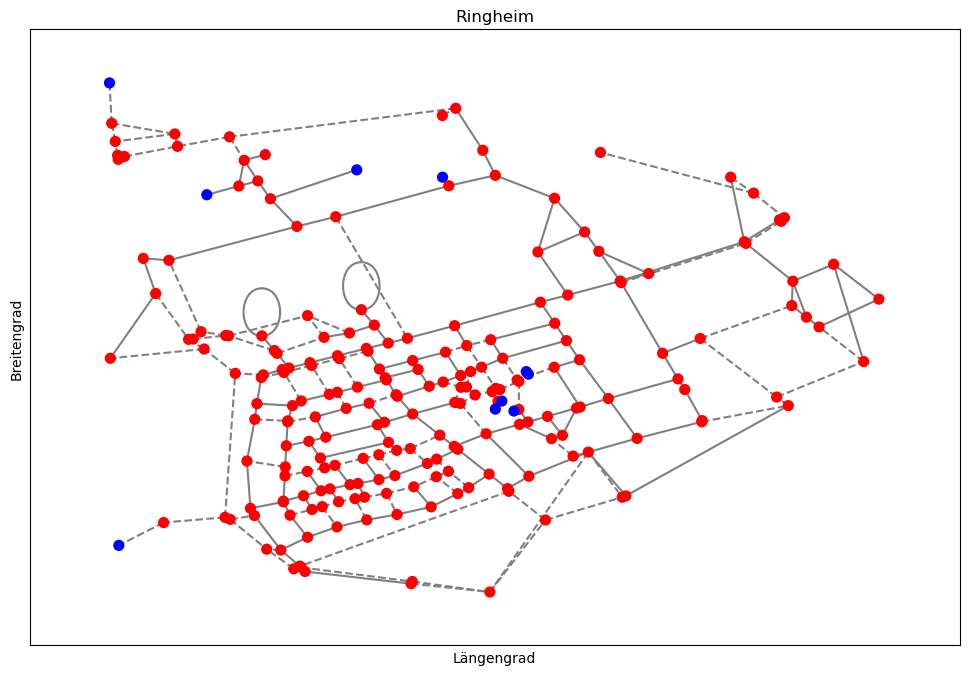

In [10]:
G = nx.Graph()

# Knoten zum Graphen hinzufügen
for index, row in filtered_data_multiple.iterrows():  
    if pd.notnull(row['longitude']) and pd.notnull(row['latitude']):
        G.add_node(row['id'], pos=(row['longitude'], row['latitude']))

# Kanten zum Graphen hinzufügen
for index, way in ways_filter.iterrows():
    node_ids_list = way['node_ids']
    if node_ids_list is not None:
        filtered_node_ids_list = [node_id for node_id in node_ids_list if G.has_node(node_id)]
        if len(filtered_node_ids_list) > 1:
            for i in range(len(filtered_node_ids_list) - 1):
                is_dashed_highway = way['tagkey'] == 'highway' and way['tagvalue'] not in ['residential', 'unclassified', 'service', 'tertiary', 'secondary']
                G.add_edge(
                    filtered_node_ids_list[i], filtered_node_ids_list[i + 1],
                    street_name=way['tagvalue'],
                    is_dashed_highway=is_dashed_highway
                )

pos = nx.get_node_attributes(G, 'pos')

plt.figure(figsize=(12, 8))

# Normale Kanten zeichnen
edges_normal = [(u, v) for u, v, d in G.edges(data=True) if not d.get('is_dashed_highway')]
nx.draw_networkx_edges(G, pos, edgelist=edges_normal, edge_color='gray', width=1.5)

# Gestrichelte Kanten zeichnen
edges_dashed = [(u, v) for u, v, d in G.edges(data=True) if d.get('is_dashed_highway')]
nx.draw_networkx_edges(G, pos, edgelist=edges_dashed, edge_color='gray', width=1.5, style='--')

node_color = ['red' if node_degrees[node] >= 3 else 'blue' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_color)

# Optional: Kantenbeschriftungen mit Straßennamen anzeigen
# edge_labels = nx.get_edge_attributes(G, 'street_name')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='red')

plt.title(title)
plt.xlabel("Längengrad")
plt.ylabel("Breitengrad")
plt.show()

### Knoten zusammenfügen, die nah beieinander stehen

In [11]:
# Zusammenführen von Knoten
def merge_close_nodes(df_nodes, threshold=5):
    while True:
        # Liste der Knoten
        node_ids = df_nodes['id'].tolist()
        node_coords = list(zip(df_nodes['longitude'], df_nodes['latitude']))
        merged_nodes = set()

        # Suche nach Knotenpaaren, die zusammengeführt werden sollen
        for i, (lon1, lat1) in enumerate(node_coords):
            for j in range(i + 1, len(node_coords)):
                lon2, lat2 = node_coords[j]
                distance = haversine(lon1, lat1, lon2, lat2)
                if distance < threshold:
                    merged_nodes.add((node_ids[i], node_ids[j]))

        # Keine weiteren Zusammenführungen nötig
        if not merged_nodes:
            break

        # Zusammenführen der gefundenen Paare
        new_nodes = []
        for node1_id, node2_id in merged_nodes:
            node1 = df_nodes[df_nodes['id'] == node1_id].iloc[0]
            node2 = df_nodes[df_nodes['id'] == node2_id].iloc[0]

            # Mittlere Position berechnen
            avg_lon = (node1['longitude'] + node2['longitude']) / 2
            avg_lat = (node1['latitude'] + node2['latitude']) / 2

            # Erstellen eines neuen Knotens
            new_node_id = min(node1_id, node2_id)
            new_nodes.append([new_node_id, avg_lon, avg_lat])

        # Aktualisieren des DataFrames
        df_new_nodes = pd.DataFrame(new_nodes, columns=['id', 'longitude', 'latitude'])
        df_nodes = pd.concat([df_nodes, df_new_nodes]).drop_duplicates(subset=['id', 'longitude', 'latitude'])

        # Entfernen alter Knoten
        nodes_to_remove = set(node1_id for node1_id, _ in merged_nodes).union(node2_id for _, node2_id in merged_nodes)
        df_nodes = df_nodes[~df_nodes['id'].isin(nodes_to_remove)]

    return df_nodes

# Anwenden der Funktion auf Knoten
df_nodes = filtered_data_multiple[filtered_data_multiple['type'] == 'node']
df_nodes = merge_close_nodes(df_nodes, threshold=5)

# Aktualisieren des DataFrames nach Zusammenführung
node_merge_dict = {node_id: node_id for node_id in df_nodes['id']}

# Aktualisieren der Straßen-IDs
def update_node_ids(node_ids):
    if node_ids is not None and isinstance(node_ids, list):
        return [node_merge_dict.get(node_id, node_id) for node_id in node_ids]
    return node_ids

filtered_data_multiple['node_ids'] = filtered_data_multiple['node_ids'].apply(update_node_ids)

# Hinzufügen der aktualisierten Knoten
filtered_data_multiple = pd.concat([filtered_data_multiple, df_nodes], ignore_index=True)
filtered_data_multiple

C:\Users\samu2\AppData\Local\Temp\ipykernel_4480\3268572273.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_multiple['node_ids'] = filtered_data_multiple['node_ids'].apply(update_node_ids)


,type,id,visible,ntags,tagkey,tagvalue,longitude,latitude,node_ids
0,way,23007687,True,2.0,highway,residential,NaN,NaN,"[248048834, 747099113]"
1,way,23007688,True,11.0,highway,residential,NaN,NaN,"[248048848, 9139728662, 571948467, 8264625521,..."
2,way,23007689,True,2.0,highway,residential,NaN,NaN,[248048886]
3,way,23008238,True,8.0,highway,residential,NaN,NaN,"[278284673, 3426708192, 570856940, 292552794, ..."
4,way,23008345,True,3.0,highway,residential,NaN,NaN,"[248048876, 248048879, 8252930929, 248048880, ..."
...,...,...,...,...,...,...,...,...,...
802,node,9195743437,True,0.0,None,None,9.035497,49.929236,None
803,node,9439430608,True,0.0,None,None,9.035857,49.928859,None
804,node,9439574977,True,0.0,None,None,9.037474,49.931042,None
805,node,10031437751,True,0.0,None,None,9.031585,49.933697,None


### Graph nach Zusammenfügen der Knoten die beieinander stehen

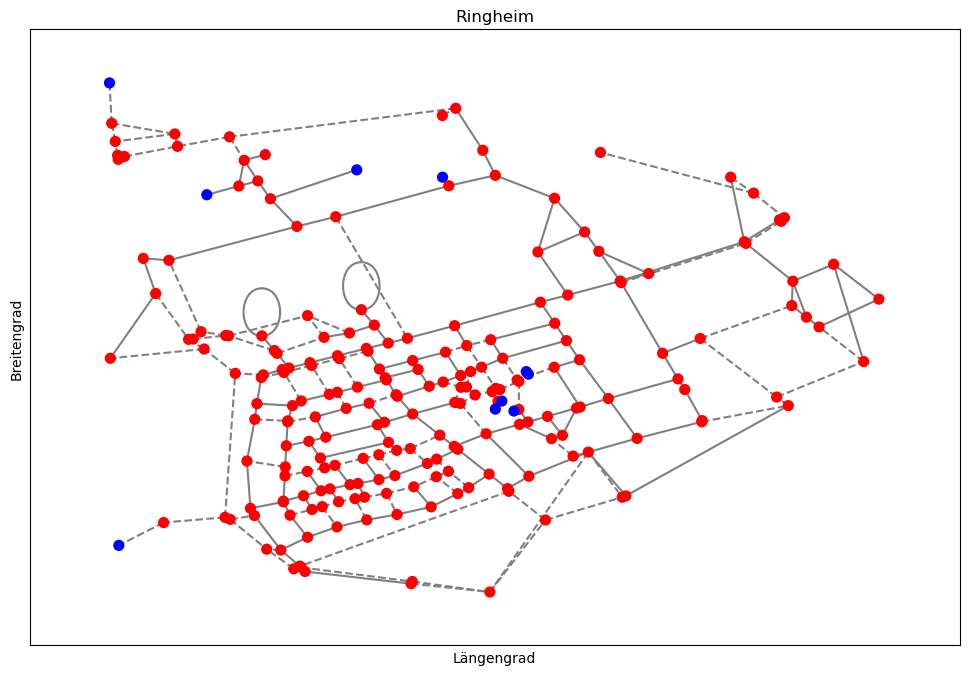

In [12]:
G = nx.Graph()

# Knoten zum Graphen hinzufügen
for index, row in filtered_data_multiple.iterrows():  
    if pd.notnull(row['longitude']) and pd.notnull(row['latitude']):
        G.add_node(row['id'], pos=(row['longitude'], row['latitude']))

# Kanten zum Graphen hinzufügen
for index, way in ways_filter.iterrows():
    node_ids_list = way['node_ids']
    if node_ids_list is not None:
        filtered_node_ids_list = [node_id for node_id in node_ids_list if G.has_node(node_id)]
        if len(filtered_node_ids_list) > 1:
            for i in range(len(filtered_node_ids_list) - 1):
                is_dashed_highway = way['tagkey'] == 'highway' and way['tagvalue'] not in ['residential', 'unclassified', 'service', 'tertiary', 'secondary']
                G.add_edge(
                    filtered_node_ids_list[i], filtered_node_ids_list[i + 1],
                    street_name=way['tagvalue'],
                    is_dashed_highway=is_dashed_highway
                )

pos = nx.get_node_attributes(G, 'pos')

plt.figure(figsize=(12, 8))

# Normale Kanten zeichnen
edges_normal = [(u, v) for u, v, d in G.edges(data=True) if not d.get('is_dashed_highway')]
nx.draw_networkx_edges(G, pos, edgelist=edges_normal, edge_color='gray', width=1.5)

# Gestrichelte Kanten zeichnen
edges_dashed = [(u, v) for u, v, d in G.edges(data=True) if d.get('is_dashed_highway')]
nx.draw_networkx_edges(G, pos, edgelist=edges_dashed, edge_color='gray', width=1.5, style='--')

node_color = ['red' if node_degrees[node] >= 3 else 'blue' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_color)

# Optional: Kantenbeschriftungen mit Straßennamen anzeigen
# edge_labels = nx.get_edge_attributes(G, 'street_name')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='red')

plt.title(title)
plt.xlabel("Längengrad")
plt.ylabel("Breitengrad")
plt.show()

In [ ]:
import plotly.graph_objects as go

node_degrees = dict(G.degree()) 

node_x = []
node_y = []
node_text = []  
node_color = [] 

for index, row in filtered_data_multiple.iterrows():
    if pd.notnull(row['longitude']) and pd.notnull(row['latitude']):
        node_x.append(row['longitude'])
        node_y.append(row['latitude'])
        
        hover_info = f"ID: {row['id']}<br>Tag Key: {row['tagkey']}<br>Tag Value: {row['tagvalue']}<br>Degree: {node_degrees[row['id']]}"
        node_text.append(hover_info)
        
        node_color.append(node_degrees[row['id']])

edge_x = []
edge_y = []
dashed_edge_x = []
dashed_edge_y = []
edge_street_names = []

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]

    # Überprüfen, ob der Rand highway != 'residual' ist
    is_dashed_highway = False
    street_name = ""
    for street in ways_filter.itertuples():
        if edge[0] in street.node_ids and edge[1] in street.node_ids:
            street_name = street.tagvalue
            # Highway-Kanten, die nicht 'residual' sind, werden gestrichelt
            if street.tagkey == "highway" and street.tagvalue not in ['residential', 'unclassified', 'service', 'tertiary', 'secondary']:
                is_dashed_highway = True
            break

    if is_dashed_highway:
        dashed_edge_x.extend([x0, x1, None])
        dashed_edge_y.extend([y0, y1, None])
    else:
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    # Berechnung der Mittelpunkte für die Straßennamen
    midpoint_x = (x0 + x1) / 2
    midpoint_y = (y0 + y1) / 2
    edge_street_names.append((midpoint_x, midpoint_y, street_name))


# Plot für durchgezogene Kanten
solid_edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Plot für gestrichelte Kanten (highways)
dashed_edge_trace = go.Scatter(
    x=dashed_edge_x, y=dashed_edge_y,
    line=dict(width=0.5, color='#888', dash='dash'),
    hoverinfo='none',
    mode='lines'
)

# Plot für Knoten
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        color=node_color,
        size=10,
        colorbar=dict(
            thickness=15,
            title='Knoten Verbindungen',
            xanchor='left',
            titleside='right'
        )),
    text=node_text
)

# Hinzufügen der Straßennamen zwischen den Knoten
street_name_trace = go.Scatter(
    x=[name[0] for name in edge_street_names],
    y=[name[1] for name in edge_street_names],
    text=[name[2] for name in edge_street_names],
    mode='text',
    textfont=dict(
        size=12,
        color='darkblue'
    ),
    hoverinfo='text'
)

layout = go.Layout(
    title='Großostheim',
    titlefont=dict(size=16),
    showlegend=False,
    hovermode='closest',
    margin=dict(b=0, l=0, r=0, t=0),
    annotations=[dict(
        text=title,
        showarrow=False,
        xref="paper", yref="paper",
        x=0.005, y=-0.002)],
    xaxis=dict(showgrid=False, zeroline=False, visible=False),
    yaxis=dict(showgrid=False, zeroline=False, visible=False)
)

fig = go.Figure(data=[solid_edge_trace, dashed_edge_trace, node_trace], layout=layout)

fig.show()


### Diagramm um den Grad der Knoten

In [ ]:
from matplotlib.ticker import MaxNLocator

degrees = list(node_degrees.values())
degree_sequence = sorted(degrees, reverse=True)

unique_degrees, counts = np.unique(degrees, return_counts=True)

fig = plt.figure(figsize=(8, 6))

plt.bar(unique_degrees, counts, color='skyblue', edgecolor='black')
plt.title("Degree Histogram of" + " " + title)
plt.xlabel("Degree")
plt.ylabel("# of Nodes")

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()

plt.show()

### Diagramm um die Länge der Straßen

In [ ]:
# Erstelle das Histogramm
plt.figure(figsize=(10, 6))
plt.hist(df_road_length['length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Verteilung der Straßenlänge'  + " " + title)
plt.xlabel('Straßenlänge (Meter)')
plt.ylabel('Anzahl der Straßen')
plt.grid(True)
plt.show()

In [ ]:
# Plot with Degree Diagrams
image_folder = 'Degree of various places'
images = [file for file in os.listdir(image_folder) if file.endswith(('png'))]

# Number of images
num_images = len(images)

cols = 3
rows = num_images // cols + (num_images % cols > 0)

fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))

for i, img_name in enumerate(images):
    img_path = os.path.join(image_folder, img_name)
    img = mpimg.imread(img_path)

    ax = axs[i // cols, i % cols] if rows > 1 else axs[i % cols]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(img_name)

for j in range(i + 1, rows * cols):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

In [ ]:
# Plot with length Diagrams
image_folder = 'Street length of various places'
images = [file for file in os.listdir(image_folder) if file.endswith(('png'))]

# Number of images
num_images = len(images)

cols = 3
rows = num_images // cols + (num_images % cols > 0)

fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))

for i, img_name in enumerate(images):
    img_path = os.path.join(image_folder, img_name)
    img = mpimg.imread(img_path)

    ax = axs[i // cols, i % cols] if rows > 1 else axs[i % cols]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(img_name)

for j in range(i + 1, rows * cols):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

# Deprecated

In [ ]:
# Knoten in Cluster zusammenfassen
coords = df_nodes_filtered_multiple[['longitude', 'latitude']].values
eps_distance = 0.0004
clustering = DBSCAN(eps=eps_distance, min_samples=1).fit(coords)

# Cluster-Labels zuweisen
df_nodes_filtered_multiple['cluster'] = clustering.labels_

# Cluster-Vertreter bestimmen
cluster_representatives = df_nodes_filtered_multiple.groupby('cluster')['id'].min().to_dict()

# Ersetzungs-Dictionary für alle Knoten -> Cluster-Vertreter
node_to_representative = {}
for node_id, cluster in df_nodes_filtered_multiple[['id', 'cluster']].values:
    if cluster in cluster_representatives:
        node_to_representative[node_id] = cluster_representatives[cluster]

print(f"node_to_representative für ID 6251639256: {node_to_representative.get(6251639256)}")

def replaces_node_ids(node_ids):
    if node_ids is None:
        return None
    # Knoten-Id in node_ids durch zugehörige Cluster-Vetreter-Id ersetzen
    replaced_node_ids = [node_to_representative.get(node_id, node_id) for node_id in node_ids]
    print(f"Original: {node_ids} -> Ersetzt: {replaced_node_ids}") 
    return replaced_node_ids

ways_filter['node_ids'] = ways_filter['node_ids'].apply(replaces_node_ids)

ways_filter['node_ids'] = ways_filter['node_ids'].apply(lambda x: list(dict.fromkeys(x)))

df_cluster_nodes = df_nodes_filtered_multiple[df_nodes_filtered_multiple['id'].isin(cluster_representatives.values())]
df_cluster_nodes = df_cluster_nodes.drop(columns='cluster')

filtered_data_combined = pd.concat([ways_filter, df_cluster_nodes], ignore_index=True)
filtered_data_combined

In [ ]:

# Funktion zur Berechnung der Straßenlänge basierend auf den referenzierten Knoten
def calculate_road_length(way_row, df_nodes):
    first_node_id = way_row['node_ids'][0]
    last_node_id = way_row['node_ids'][-1]

    # Überprüfe, ob der erste Knoten im DataFrame existiert
    first_node = df_nodes[df_nodes['id'] == first_node_id]
    if first_node.empty:
        print(f"Warnung: Erster Knoten mit ID {first_node_id} nicht gefunden!")
        return 0 

    # Überprüfe, ob der letzte Knoten im DataFrame existiert
    last_node = df_nodes[df_nodes['id'] == last_node_id]
    if last_node.empty:
        print(f"Warnung: Letzter Knoten mit ID {last_node_id} nicht gefunden!")
        return 0 

    # Berechne die Entfernung zwischen den Knoten
    length = haversine(first_node['longitude'].values[0], first_node['latitude'].values[0],
                       last_node['longitude'].values[0], last_node['latitude'].values[0])
    return length

filtered_data_combined['road_length'] = filtered_data_combined[filtered_data_combined['type'] == 'way'].apply(calculate_road_length, axis=1, df_nodes=df_cluster_nodes)
filtered_data_combined